# The Issue Description

Consider that our marketplace has following data:
- orders table: transactions related to orders proceeded by our customers in some clothes brands
- order revisions table: each order consists of some items and current customers choice should be stored after some events. Customers can change something before final payment or cancelling the order so we need to use last revision per each order. 
- order revision items table: each revision consists of some number of same or different items. 

The sense of this issue is to create method of calculation the inflation in our marketplace.

In [1]:
import sqlite3 as sl
import pandas as pd
import typing as tp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_orders = pd.read_excel("orders.xlsx")
df_order_revision_item = pd.read_excel("order_revision_item.xlsx")
df_order_revision = pd.read_excel("order_revision.xlsx")

In [3]:
def simpe_review(df: tp.Any) -> str:
    print(
    "The structure of the table."
    +"\n\n"
    +"The size of the sample: " + str(df.shape[0]) + " rows"
    +"\n\n"
    +str(df.dtypes)
    )

In [4]:
simpe_review(df_orders)

The structure of the table.

The size of the sample: 222481 rows

brand_id                      int64
brand_name                   object
country_name                 object
currency_rate               float64
order_date                   object
order_id                      int64
order_latest_revision_id    float64
order_payment               float64
region_name                  object
dtype: object


In [5]:
simpe_review(df_order_revision_item)

The structure of the table.

The size of the sample: 991719 rows

composition_id     int64
id                 int64
name              uint64
price              int64
dtype: object


In [6]:
simpe_review(df_order_revision)

The structure of the table.

The size of the sample: 221675 rows

composition_id    int64
id                int64
dtype: object


# Data Preparation

We're going to solve the issue using sql. 

In [7]:
def insert_to_db(sql_drop: str, sql_create: str, sql_insert: str, df_ins: tp.Any, con: tp.Any, cur: tp.Any) -> str:
    """
    UDF for creating tables and inserting data using sqlite3
    """
    
    #I've noticed SQLITE usually convert int data to blob type, so let's convert it
    for i, column in enumerate(df_ins.columns):
        if df_ins[column].dtype == 'int64':
            df_ins[column] = df_ins[column].astype(object)
    
    #connection to db
    with con:
        try:
            cur.execute(sql_drop)
            cur.execute(sql_create)

            #inserting data to table
            for i in range(df_ins.shape[0]):
                data = []
                data.append(tuple(df_ins.loc[i]))            
                cur.executemany(sql_insert, data)  

        except sl.DatabaseError as err:       
            return("Error: ", err)
        else:
            con.commit()
    return("Data was successfully inserted")    

In [8]:
sql_drop = "drop table if exists orders;"
sql_create = """
            create table orders
            (
                brand_id int 
                , brand_name text 
                , country_name text 
                , currency_rate real 
                , order_date text 
                , order_id int 
                , order_latest_revision_id int 
                , order_payment real 
                , region_name text 
            );
            """
sql_insert = "insert into orders (brand_id, brand_name, country_name, currency_rate, order_date, order_id, order_latest_revision_id, order_payment, region_name) values (?, ?, ?, ?, ?, ?, ?, ?, ?);"

con = sl.connect("my_db.db")
cur = con.cursor()

insert_to_db(sql_drop, sql_create, sql_insert, df_ins = df_orders, con = con, cur = cur)

'Data was successfully inserted'

In [9]:
sql_drop = "drop table if exists order_revision;"
sql_create = """
            create table order_revision
            (
                composition_id INTEGER 
                , id INTEGER 
            );
            """
sql_insert = "insert into order_revision(composition_id, id) values (?, ?);"

con = sl.connect("my_db.db")
cur = con.cursor()

insert_to_db(sql_drop, sql_create, sql_insert, df_ins = df_order_revision, con = con, cur = cur)

'Data was successfully inserted'

In [10]:
sql_drop = "drop table if exists order_revision_item;"
sql_create = """
            create table order_revision_item 
            (
                composition_id int
                , id int
                , name int 
                , price real 
            );
            """
sql_insert = "insert into order_revision_item(composition_id, id, name, price) values (?, ?, ?, ?);"

con = sl.connect("my_db.db")
cur = con.cursor()

insert_to_db(sql_drop, sql_create, sql_insert, df_ins = df_order_revision_item, con = con, cur = cur)

'Data was successfully inserted'

# The Solution Logic

A price of each item could have its own rising or falling dynamics. We are going to calculate two different types of it:
- Perceived inflation (i.e. average inflation per all items)
- Fact inflation (i.e. weighted inflation per all items which should be depended on the a percentage share of selected item in overall GMV)

Consider the following example:

1) At some start datepoint we sold 5 pairs of jeans each for 20 USD and 4 shirts each for 25 USD.
2) At some end datepoint we sold 4 pairs of jeans each for 25 USD and 5 shirts each still for 25 USD.

The inflation rate of jeans is equal to (25 - 20) / 20 = 25% as well as 0% for shirts because its price is the same. 

The average inflation in this case would be (25% + 0%) / 2 = 12.5%

The weighted one would be: 
- jeans part: {(4 * 25) / [ (4 * 25) + (5 * 25) ] } * 0.25 
- plus
- shirts part: {(5 * 25) / [ (4 * 25) + (5 * 25) ] } * 0

That's equal to 11.1%

Well, according to existing data let's solve it via SQl.

In [16]:
sql = """
--create the common table via many-to-many relations for three tables
with orders_mart as 
(
    select 
    o.order_id as order_id
    , o.brand_id as brand_id
    , o.brand_name as brand_name
    , o.country_name as country_name
    , date(o.order_date) as order_date
    , strftime('%W', o.order_date) as order_week
    , o.order_payment as order_payment
    , o.region_name as region_name
    , ori.id as item_id 
    , ori.name as item_name 
    , coalesce( (ori.price * o.currency_rate) , 0) as item_price

    from orders as o 
    left join order_revision as ore 
    on o.order_latest_revision_id = ore.id
    left join order_revision_item as ori 
    on ori.composition_id = ore.composition_id
),

--all inflation rates would be allocated to start of weeks 
week_date as 
(
    select 
    order_week
    , min(order_date) as week_start
    from orders_mart
    group by order_week
)


select 
brand_name
, country_name
, region_name
, wd.week_start as week_start
, perceived_inflation
, fact_inflation
, perceived_inflation_temp
, fact_inflation_temp
from 
(
    select 
    brand_name
    , country_name
    , region_name
    , order_week
    , avg(item_infl_start) as perceived_inflation
    , sum(item_infl_start * items_rate) as fact_inflation
    , avg(item_infl_wow) as perceived_inflation_temp
    , sum(item_infl_wow * items_rate) as fact_inflation_temp
    from 
    (
        select 
        brand_name
        , country_name
        , region_name
        , order_week
        , item_name
        , items_cnt
        , gmv_weekly
        , items_rate
        , item_price_weekly
        , item_price_start
        , ((item_price_weekly - item_price_start) / item_price_start) as item_infl_start
        , item_price_prev_week
        , ((item_price_weekly - coalesce(item_price_prev_week,item_price_weekly)) / coalesce(item_price_prev_week, 1)) as item_infl_wow
        from 
        (
            select 
            brand_name
            , country_name
            , region_name
            , order_week
            , item_name
            , items_cnt
            
            --weekly gmv of brand in region per week
            , sum(items_cnt * item_price_weekly) over (partition by country_name, brand_name, region_name, order_week) as gmv_weekly
            
            --a share of selected item in weekly gmv of brand in region per week
            , (items_cnt * item_price_weekly) / (sum(items_cnt * item_price_weekly) over (partition by country_name, brand_name, region_name, order_week)) as items_rate

            , round(item_price_weekly) as item_price_weekly
            
            --start point for inflation rate calculating
            , round( max ( case when order_week = min_order_week then item_price_weekly else null end ) over (partition by country_name, brand_name, region_name, item_name) ) as item_price_start

            --not the case of this issue exactly but it's also useful to look at inflation temp week over week
            , round( lag(item_price_weekly, -1) over (partition by country_name, brand_name, region_name, item_name order by order_week desc) ) as item_price_prev_week
            from 
            (
                select 
                brand_name
                , country_name
                , order_week
                , region_name
                , item_name 
                , item_price_weekly
                , items_cnt
                , max(order_week) over (partition by country_name, brand_name, region_name, item_name) as max_order_week
                , min(order_week) over (partition by country_name, brand_name, region_name, item_name) as min_order_week
                from 
                (
                    select 
                    brand_name
                    , country_name
                    , order_week
                    , region_name
                    , item_name 
                    , avg(item_price) as item_price_weekly --price of the same item at the same brand could be a bit different
                    , count(*) as items_cnt
                    from orders_mart 
                    group by 
                    brand_name
                    , country_name
                    , order_week
                    , region_name
                    , item_name 
                )
                group by 
                brand_name
                , country_name
                , order_week
                , region_name
                , item_name 
                , item_price_weekly
                , items_cnt
            )
            where min_order_week = '10' --this sample example consists of one month only 
            and max_order_week = '13'
        )
    )
    group by 
    brand_name
    , country_name
    , region_name
    , order_week
) as t
inner join week_date as wd
on wd.order_week = t.order_week

order by 
country_name
, region_name
, brand_name
, week_start
"""

con = sl.connect("my_db.db")
df_final_res = pd.read_sql_query(sql, con)
df_final_res

,brand_name,country_name,region_name,week_start,perceived_inflation,fact_inflation,perceived_inflation_temp,fact_inflation_temp
0,Casual Clothes Brand,Germany,Berlin,2022-03-07,0.000000,0.000000,0.000000,0.000000
1,Casual Clothes Brand,Germany,Berlin,2022-03-14,0.026121,0.036135,0.026121,0.036135
2,Casual Clothes Brand,Germany,Berlin,2022-03-21,0.051854,0.065663,0.027942,0.035916
3,Casual Clothes Brand,Germany,Berlin,2022-03-28,0.058818,0.060873,0.010992,0.002176
4,Office Costumes,Germany,Berlin,2022-03-07,0.000000,0.000000,0.000000,0.000000
5,Office Costumes,Germany,Berlin,2022-03-14,-0.001107,-0.001253,-0.001107,-0.001253
6,Office Costumes,Germany,Berlin,2022-03-21,0.002544,-0.006095,0.004173,0.001040
7,Office Costumes,Germany,Berlin,2022-03-28,0.021179,0.004773,0.018281,0.006516
8,Sportswear,Germany,Berlin,2022-03-07,0.000000,0.000000,0.000000,0.000000
9,Sportswear,Germany,Berlin,2022-03-14,0.004248,0.006637,0.004248,0.006637


# Visualization and Usage

Now we can use this data for checking the weekly dynamics of both inflation types per brands and regions.

In [13]:
def inflation_per_brand_in_region(
    df: tp.Any
    , brands_input: tp.Optional[tp.List[str]] = None
    , cities_input: tp.Optional[tp.List[str]] = None
) -> tp.Any:
    """
    UDF for vizualization of inflation rate per brands and cities 
    """
    #any values of brands and cities should be selected
    res_error = ""
    
    if brands_input is None or len(brands_input) == 0:
        res_error = "Please select any brand"
        return res_error

    if cities_input is None or len(cities_input) == 0:
        res_error = "Please select any city"
        return res_error

    #continue in case of any values were selected
    for brand in brands_input:
        
        #generate new df with mentioned in arguments brands
        df_new = df.copy()
        df_new = df_new.loc[lambda df_new: df_new.brand_name == brand]
        
        #brand names validation => return errror message in case of incorrect brand
        if df_new.shape[0] == 0:
            res_error = "Brand " + str(brand) + " seems to be incorrect"
            print (res_error)
        
        #continue algorithm for correct brand names
        else:
            
            #define all available cities for each correct brand and return corresponded data
            cities_available = set(df_new.region_name)
            cities_input = set(cities_input)
            
            cities_union = set.intersection(cities_available, cities_input)
            cities_minus = cities_input.difference(cities_available)
            
            #udf should be broken in case of no matching between brands and cities
            if len(cities_union) == 0:
                res_error = "No one brand is available in mentioned cities"
                return res_error
                break 
                
            #in case if we have some match let's return firstly cities without pair
            if len(cities_minus) != 0:
                res_error = "Brand " + str(brand) + " is not available in " + str(cities_minus)
                print (res_error)
            
            #finally we're going to work with matched pairs of cities and brands
            num = len(cities_union)
            
            res_succ = "Brand " + str(brand) + " is available in " + str(cities_union)
            print("")
            print (res_succ)
            print("")
            
            #create a separete chart per each correct pair of city and brand
            for i, value in enumerate(cities_union):
                df_viz = df_new.loc[lambda df_new: df_new.region_name == value]

                #figure parameteres 
                fig, ax = plt.subplots(figsize=(15,6))
                width = 0.3

                #for x ax
                x = np.array(df_viz.index)
                x_label = sorted(set(df_viz.week_start))

                # setting ticks for x-axis
                ax.set_xticks(x)

                # setting label for x tick
                ax.set_xticklabels(x_label)

                #for y ax values
                y_per = df_viz.perceived_inflation
                y_fact = df_viz.fact_inflation

                #for bars 
                plt.bar(df_viz.index - width / 2, y_per, width, color='darkorange', label='perceived_inflation')
                plt.bar(df_viz.index + width / 2, y_fact, width, color='deepskyblue', label='fact_inflation')

                #for y ax values
                y_offset = max(y_per) / 1000
                for i, y in enumerate(y_per):
                    ax.text(y_per.index[i] - width / 2, y + y_offset, str(round((y * 100), 2)) + "%", ha='center', weight='bold')
                y_offset = max(y_fact) / 1000
                for i, y in enumerate(y_fact):
                    ax.text(y_fact.index[i] + width / 2, y + y_offset, str(round((y * 100), 2)) + "%", ha='center', weight='bold')

                plt.ylabel('Inflation rate', fontsize = 15)

                title = "Inflation of brand " + brand + " in " + value
                plt.title(title, fontsize = 15)

                plt.legend(fontsize = 15)
                plt.show()

For example, I want to understand the result certain brand in certain region. 


Brand Office Costumes is available in {'New York'}



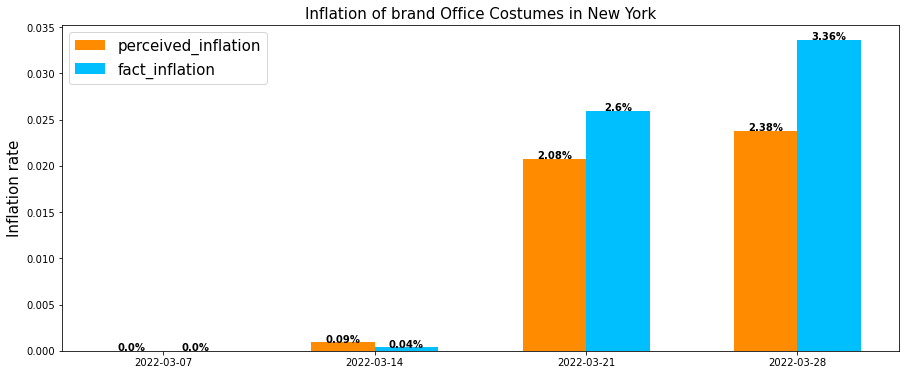

In [14]:
select_brands = ["Office Costumes"]
select_cities = ["New York"]
inflation_per_brand_in_region(df_final_res, select_brands, select_cities)

For sure, I can select several brands and cities and sometimes make mistakes in such selecting.

Brand Casual Clothes Brand is not available in {'Riga'}

Brand Casual Clothes Brand is available in {'New York'}



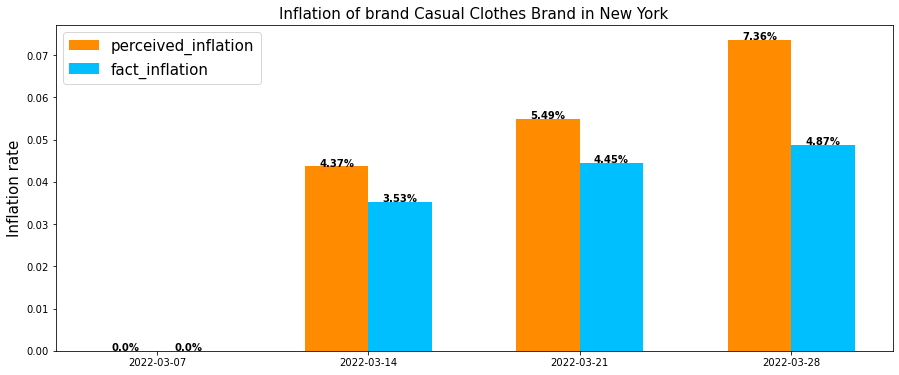

Brand Sportswear is not available in {'Riga'}

Brand Sportswear is available in {'New York'}



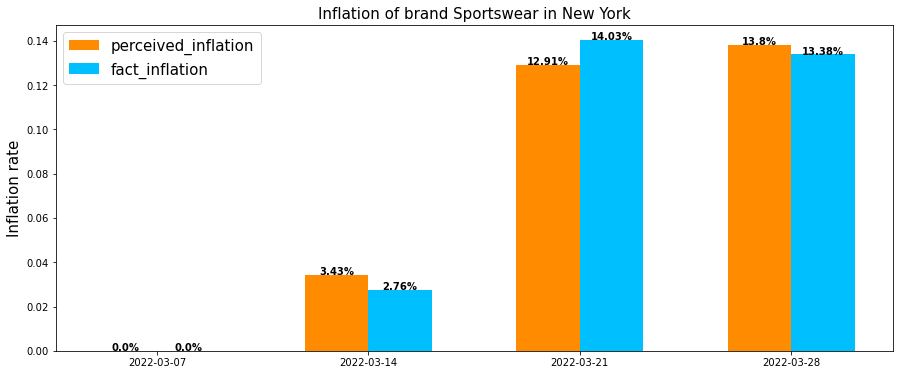

Brand KKK seems to be incorrect


In [15]:
select_brands = ["Casual Clothes Brand", "Sportswear", "KKK"]
select_cities = ["Riga", "New York"]
inflation_per_brand_in_region(df_final_res, select_brands, select_cities)